In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'lm',
    'font.size': '11',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import matplotlib.pyplot as plt
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
import pandas as pd
MODALITY = 'asymmetry'
IMPUTE_ID = 'mean_imputed'
SUBSAMPLED_ID = 'not_subsampled'
PARTITIONS_DIR = f"../../results/{MODALITY}/visualizeCCAOnPheno/joinedDatasets/{IMPUTE_ID}/{SUBSAMPLED_ID}/props"
RESULTS_DIR = f"../../results/{MODALITY}/FUMA/joinedDatasets/{IMPUTE_ID}/{SUBSAMPLED_ID}"

In [2]:
import numpy as np
def load_df(name):
    df = None
    for par in [1,4,5,6,7]:
        tab = pd.read_csv(f"{RESULTS_DIR}/par{par:02d}/magma_exp_bs_{name}_avg_log2RPKM.gsa.out",delim_whitespace=True, comment="#")
        tab['partition'] = par
        tab['log10p'] = -np.log10(tab['P'])
        if df is None:
            df = tab
        else:
            df = pd.concat([df, tab])
    return df
age_df = load_df("age")
dev_df = load_df("dev")

In [3]:
age_df.shape

(145, 9)

In [4]:
dev_df.head()

,VARIABLE,TYPE,NGENES,BETA,BETA_STD,SE,P,partition,log10p
0,Early_prenatal,COVAR,13428,0.010693,0.016091,0.009937,0.140960,1,0.850904
1,Early_mid-prenatal,COVAR,13428,0.017013,0.025529,0.011329,0.066589,1,1.176598
2,Late_mid-prenatal,COVAR,13428,0.015660,0.023187,0.013909,0.130120,1,0.885656
3,Late_prenatal,COVAR,13428,0.020490,0.028119,0.016073,0.101200,1,0.994819
4,Early_infancy,COVAR,13428,-0.031833,-0.045051,0.028026,0.871970,1,0.059498


In [5]:
age_labs = age_df.VARIABLE.unique().tolist()
dev_labs = dev_df.VARIABLE.unique().tolist()

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.gridspec import GridSpec
def create_development_figure(df):
    labs = df['VARIABLE'].unique()
    df = df.pivot('VARIABLE','partition','log10p').loc[labs]
    fig = plt.figure(figsize=(40, 8))
    spec = GridSpec(2, len(df.columns), hspace=0, wspace=0.08)
    ymax = np.max(df.max())
    for i,col in enumerate(df.columns):
        ax0 = fig.add_subplot(spec[0,i], xticks=[], yticks=[])
        title = r'\textbf{Partition ' + str(col) + r'}'
        ax0.set_title(title)
        with Image.open(PARTITIONS_DIR + '/' + str(col) + '.png') as im:
            ax0.imshow(im)
            ax0.axis('off')
        if i == 0:
            ax1 = fig.add_subplot(spec[1,i])
        else:
            ax1 = fig.add_subplot(spec[1,i], yticks=[])
        xaxis = np.arange(len(df.index))
        cutoff = -np.log10(0.05/len(df))
        m = df[col] >= cutoff
        bar0 = ax1.bar(xaxis[~m],df[~m][col], color='blue')
        bar1 = ax1.bar(xaxis[m],df[m][col], color='red')
        bars = [b for b in bar0] + [b for b in bar1]
        x_min = np.array([plt.getp(item, 'x') for item in bars])
        x_max = x_min + [plt.getp(item, 'width') for item in bars]
        ax1.set_xticks(xaxis)
        ax1.set_xticklabels([x.replace('_',' ') for x in df.index], rotation = 90)

        ax1.hlines(cutoff,min(x_min), max(x_max),linestyles='dotted')
        ax1.set_ylim([0, 1.1* max(ymax, cutoff)])
        if i==0:
            ax1.set_ylabel('-log10p')
    return fig

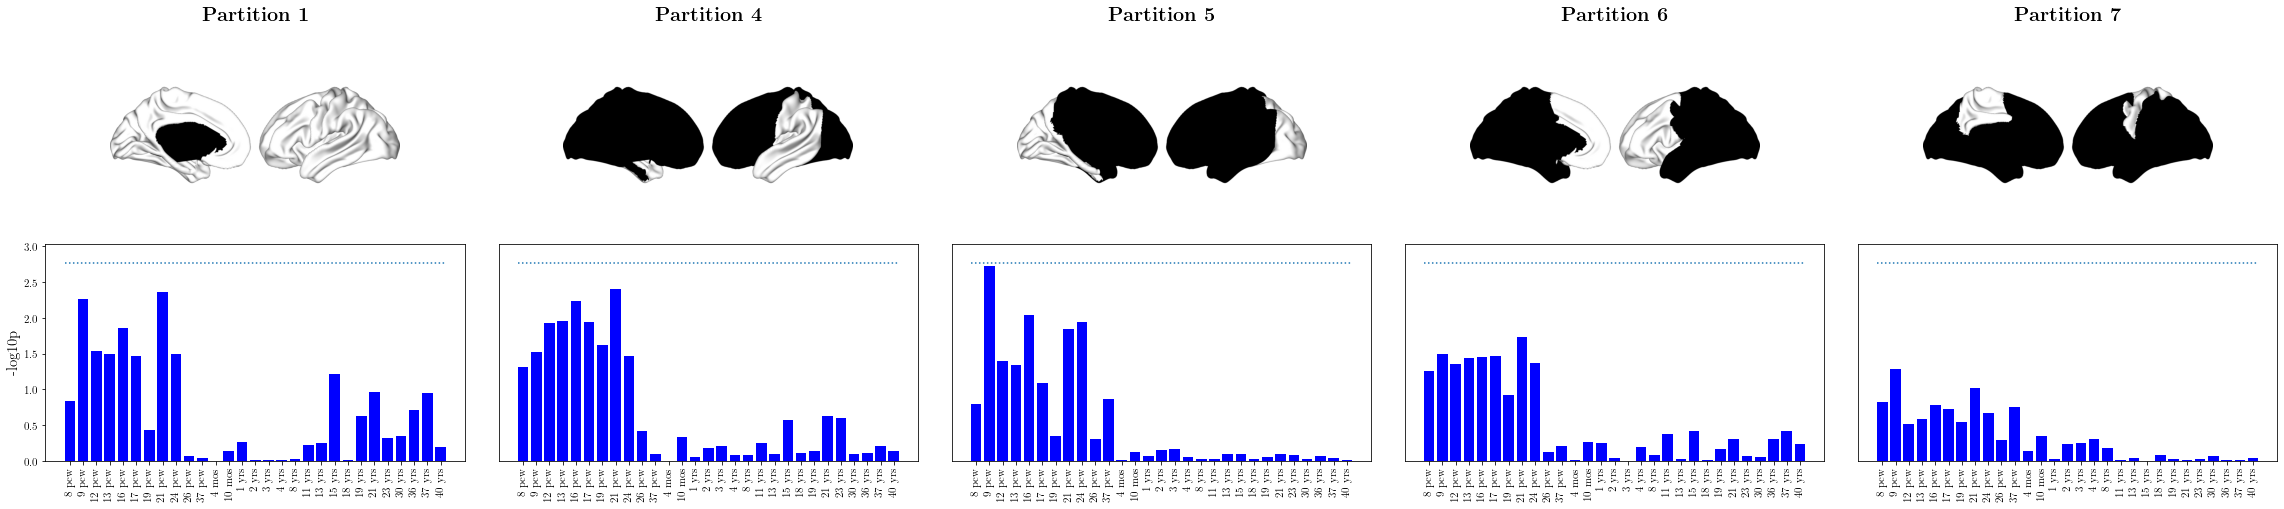

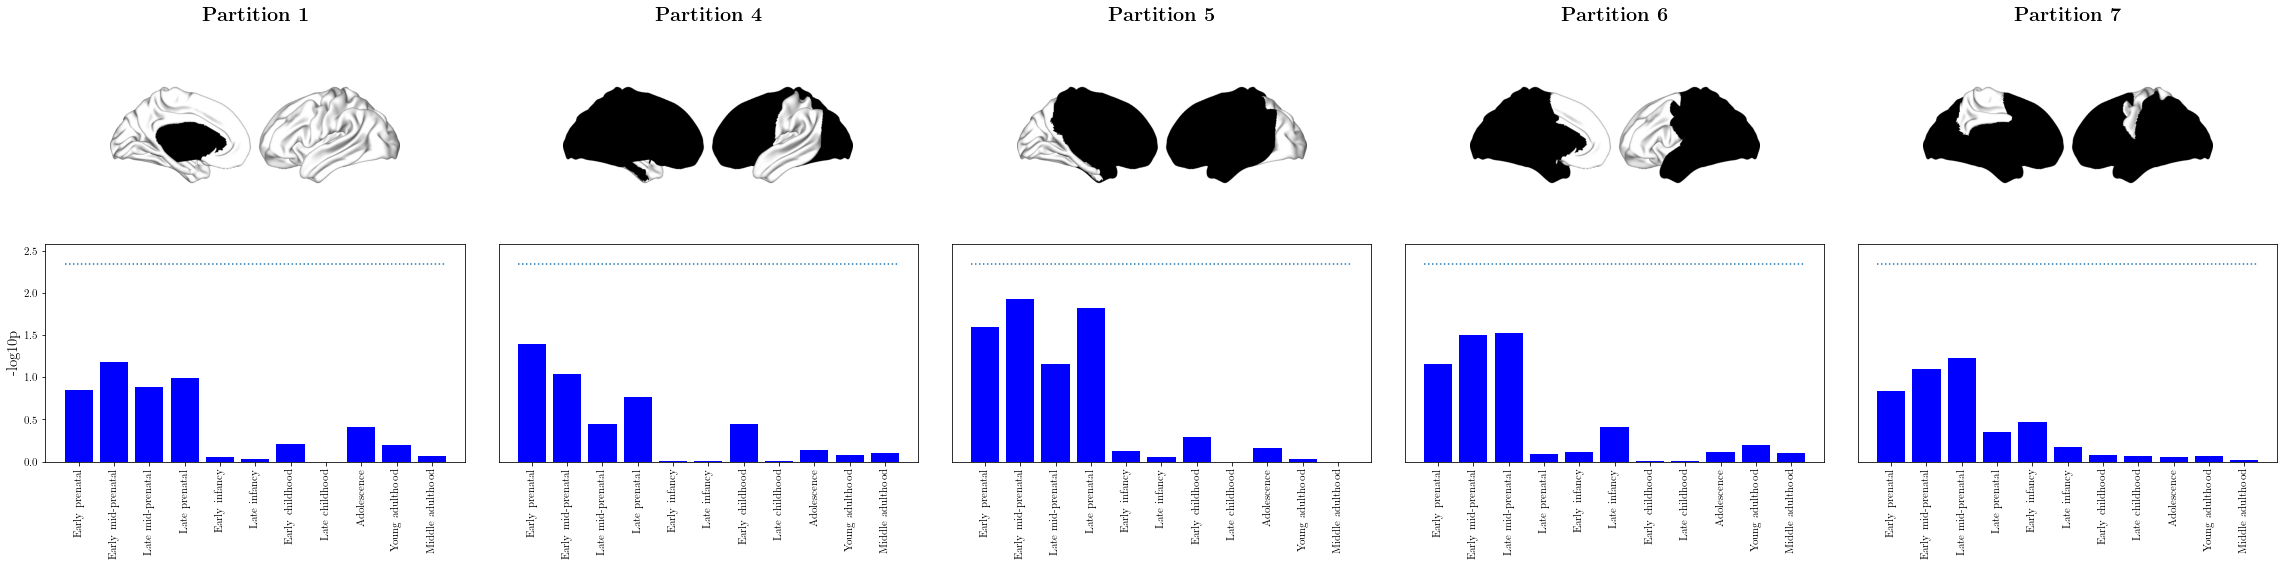

In [9]:
age_fig = create_development_figure(age_df)
dev_fig = create_development_figure(dev_df)

In [10]:
import os
OUTPUT_DIR = RESULTS_DIR+'/partitionsSummary/'
os.makedirs(OUTPUT_DIR,exist_ok=True)

age_fig.savefig(OUTPUT_DIR + 'age.pdf', bbox_inches="tight")
dev_fig.savefig(OUTPUT_DIR + 'dev.pdf', bbox_inches="tight")